In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2


In [3]:
DATASET = "polyp"
BASE_DIR = f"/home/vblot/multiaccurate_cp/data/{DATASET}"
MODELS_PATH = f"/home/vblot/multiaccurate_cp/data/{DATASET}/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [4]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
config

{'mean_RGB_values_path': None,
 'ml_data_dir': 'data/polyp/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/polyp/03_model_weights/resnet',
 'polyp': True,
 'probas_dir': 'data/polyp/04_predictions'}

In [6]:
IMG_SIZE = 64
EMBEDDING_SIZE = config["model"]["embedding_size"]

In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
c_pp, c_re, c_l = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


0it [00:00, ?it/s]

4it [00:00, 31.23it/s]

11it [00:00, 49.29it/s]

18it [00:00, 52.26it/s]

27it [00:00, 64.16it/s]

34it [00:00, 65.68it/s]

41it [00:00, 59.17it/s]

48it [00:00, 58.34it/s]

55it [00:00, 61.16it/s]

62it [00:01, 59.81it/s]

69it [00:01, 62.14it/s]

76it [00:01, 64.00it/s]

83it [00:01, 65.36it/s]

90it [00:01, 66.48it/s]

97it [00:01, 64.76it/s]

104it [00:01, 54.11it/s]

111it [00:01, 57.87it/s]

118it [00:01, 60.77it/s]

125it [00:02, 48.90it/s]

131it [00:02, 51.18it/s]

138it [00:02, 55.61it/s]

145it [00:02, 59.05it/s]

152it [00:02, 61.71it/s]

159it [00:02, 47.59it/s]

165it [00:03, 24.68it/s]

170it [00:03, 21.63it/s]

174it [00:04, 18.66it/s]

177it [00:04, 19.06it/s]

180it [00:04, 17.61it/s]

183it [00:04, 18.29it/s]

186it [00:04, 18.94it/s]

189it [00:04, 19.50it/s]

192it [00:04, 19.94it/s]

195it [00:05, 14.72it/s]

197it [00:05, 14.97it/s]

200it [00:05, 16.46it/s]

203it [00:05, 15.06it/s]

205it [00:05, 15.66it/s]

208it [00:06, 17.15it/s]

211it [00:06, 18.23it/s]

213it [00:06, 16.81it/s]

215it [00:06, 17.02it/s]

217it [00:06, 17.24it/s]

219it [00:06, 17.68it/s]

222it [00:06, 19.01it/s]

226it [00:06, 22.66it/s]

233it [00:07, 33.40it/s]

240it [00:07, 42.50it/s]

246it [00:07, 45.63it/s]

252it [00:07, 49.37it/s]

252it [00:07, 34.28it/s]

In [10]:
t_pp, t_re, t_l = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

0it [00:00, ?it/s]

6it [00:00, 57.77it/s]

14it [00:00, 65.39it/s]

21it [00:00, 66.23it/s]

28it [00:00, 66.60it/s]

36it [00:00, 68.34it/s]

43it [00:00, 44.03it/s]

49it [00:00, 46.25it/s]

56it [00:01, 51.86it/s]

62it [00:01, 46.77it/s]

72it [00:01, 59.26it/s]

90it [00:01, 87.98it/s]

100it [00:01, 77.24it/s]

109it [00:01, 71.94it/s]

117it [00:01, 71.07it/s]

125it [00:02, 40.06it/s]

131it [00:02, 38.91it/s]

139it [00:02, 44.97it/s]

146it [00:02, 49.12it/s]

153it [00:02, 44.60it/s]

160it [00:02, 49.31it/s]

168it [00:03, 54.54it/s]

175it [00:03, 56.36it/s]

182it [00:03, 59.45it/s]

190it [00:03, 62.26it/s]

197it [00:03, 63.85it/s]

205it [00:03, 65.82it/s]

212it [00:03, 65.47it/s]

219it [00:03, 59.71it/s]

226it [00:03, 58.76it/s]

232it [00:04, 58.05it/s]

240it [00:04, 62.05it/s]

247it [00:04, 59.21it/s]

254it [00:04, 61.96it/s]

262it [00:04, 64.10it/s]

269it [00:04, 64.48it/s]

277it [00:04, 66.29it/s]

284it [00:04, 66.98it/s]

291it [00:04, 67.41it/s]

298it [00:05, 66.83it/s]

305it [00:05, 67.65it/s]

312it [00:05, 67.94it/s]

320it [00:05, 69.30it/s]

327it [00:05, 68.49it/s]

335it [00:05, 68.90it/s]

342it [00:05, 62.57it/s]

349it [00:06, 38.73it/s]

355it [00:06, 23.58it/s]

359it [00:06, 23.41it/s]

363it [00:07, 19.92it/s]

366it [00:07, 19.55it/s]

369it [00:07, 12.67it/s]

371it [00:08, 11.30it/s]

374it [00:08, 12.96it/s]

376it [00:08, 11.19it/s]

378it [00:08, 12.18it/s]

381it [00:08, 14.14it/s]

383it [00:08, 14.51it/s]

385it [00:09, 12.31it/s]

387it [00:09, 13.44it/s]

390it [00:09, 15.58it/s]

392it [00:09, 16.32it/s]

394it [00:09, 16.81it/s]

396it [00:09, 17.05it/s]

398it [00:09, 17.20it/s]

401it [00:09, 18.46it/s]

404it [00:10, 19.33it/s]

406it [00:10, 18.37it/s]

408it [00:10, 18.38it/s]

411it [00:10, 18.71it/s]

413it [00:10, 18.92it/s]

415it [00:10, 18.86it/s]

417it [00:10, 18.30it/s]

419it [00:10, 17.79it/s]

422it [00:11, 18.91it/s]

424it [00:11, 19.02it/s]

426it [00:11, 18.52it/s]

428it [00:12,  4.93it/s]

430it [00:12,  5.15it/s]

433it [00:12,  7.18it/s]

435it [00:13,  8.02it/s]

437it [00:13,  8.41it/s]

440it [00:13, 11.01it/s]

443it [00:13, 13.30it/s]

445it [00:13, 14.26it/s]

447it [00:14, 10.84it/s]

450it [00:14, 13.30it/s]

453it [00:14, 15.24it/s]

455it [00:14, 13.15it/s]

457it [00:14, 13.93it/s]

459it [00:14, 14.84it/s]

462it [00:14, 16.74it/s]

465it [00:15, 18.11it/s]

468it [00:15, 18.73it/s]

470it [00:15, 18.45it/s]

472it [00:15, 18.05it/s]

475it [00:15, 18.88it/s]

478it [00:15, 21.12it/s]

484it [00:15, 29.72it/s]

490it [00:15, 36.05it/s]

497it [00:16, 42.70it/s]

504it [00:16, 48.40it/s]

511it [00:16, 50.50it/s]

518it [00:16, 53.96it/s]

525it [00:16, 57.81it/s]

531it [00:16, 53.14it/s]

538it [00:16, 55.55it/s]

546it [00:16, 53.10it/s]

546it [00:16, 32.34it/s]

In [11]:
all_pred_probas = np.concatenate([c_pp, t_pp])
all_res_emb = np.concatenate([c_re, t_re])
all_labels = np.concatenate([c_l, t_l])

all_pred_probas.shape, all_res_emb.shape, all_labels.shape

((798, 64, 64), (798, 1024), (798, 64, 64))

In [12]:
ALPHA = .1

In [13]:
recalls = []
precisions = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]
    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    n = len(temp_cal_pred_probas)

    result = minimize(
        J, np.random.uniform(0, 1, EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, n), jac=J_prime,
        options={"disp": False, "maxiter": 10000}
    )

    ths = np.maximum((temp_test_res_emb @ result.x).reshape(-1, 1, 1), -np.inf)
    y_pred_test_th = (temp_test_pred_probas >= ths).astype(int)
    recall_test = (y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / temp_test_labels.sum(axis=(1, 2))
    precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
    recalls.append(np.nanmean(recall_test))
    precisions.append(np.nanmean(precision_test))
    print(np.nanmean(recall_test))

    


  0%|                                                                                                                                                                                                             | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1682248/2774270312.py:26: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * temp_test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
  1%|█▉                                                                                                                                                                                                   | 1/100 [00:06<10:22,  6.29s/it]

0.0834129595413892


  2%|███▉                                                                                                                                                                                                 | 2/100 [00:13<10:45,  6.58s/it]

0.11728248888124672


  3%|█████▉                                                                                                                                                                                               | 3/100 [00:19<10:36,  6.56s/it]

0.0


  4%|███████▉                                                                                                                                                                                             | 4/100 [00:25<10:22,  6.48s/it]

1.0


  5%|█████████▊                                                                                                                                                                                           | 5/100 [00:32<10:09,  6.42s/it]

0.0


  6%|███████████▊                                                                                                                                                                                         | 6/100 [00:39<10:16,  6.56s/it]

0.35825679044077097


  7%|█████████████▊                                                                                                                                                                                       | 7/100 [00:45<09:55,  6.40s/it]

0.0


  8%|███████████████▊                                                                                                                                                                                     | 8/100 [00:51<09:50,  6.42s/it]

0.005126267317124922


  9%|█████████████████▋                                                                                                                                                                                   | 9/100 [00:58<09:42,  6.40s/it]

0.38667227675665705


 10%|███████████████████▌                                                                                                                                                                                | 10/100 [01:04<09:43,  6.48s/it]

0.0


 11%|█████████████████████▌                                                                                                                                                                              | 11/100 [01:11<09:39,  6.52s/it]

0.0


 12%|███████████████████████▌                                                                                                                                                                            | 12/100 [01:18<09:39,  6.59s/it]

0.0


 13%|█████████████████████████▍                                                                                                                                                                          | 13/100 [01:24<09:32,  6.58s/it]

0.0


 14%|███████████████████████████▍                                                                                                                                                                        | 14/100 [01:31<09:35,  6.70s/it]

0.0


 15%|█████████████████████████████▍                                                                                                                                                                      | 15/100 [01:37<09:21,  6.60s/it]

0.0


 16%|███████████████████████████████▎                                                                                                                                                                    | 16/100 [01:44<09:20,  6.67s/it]

0.0


 17%|█████████████████████████████████▎                                                                                                                                                                  | 17/100 [01:51<09:08,  6.61s/it]

0.7528955078508094


 18%|███████████████████████████████████▎                                                                                                                                                                | 18/100 [01:58<09:11,  6.72s/it]

0.0


 19%|█████████████████████████████████████▏                                                                                                                                                              | 19/100 [02:05<09:07,  6.76s/it]

0.0


 20%|███████████████████████████████████████▏                                                                                                                                                            | 20/100 [02:11<08:59,  6.75s/it]

0.5575954875016433


 21%|█████████████████████████████████████████▏                                                                                                                                                          | 21/100 [02:18<08:41,  6.60s/it]

1.0


 22%|███████████████████████████████████████████                                                                                                                                                         | 22/100 [02:24<08:30,  6.54s/it]

0.0


 23%|█████████████████████████████████████████████                                                                                                                                                       | 23/100 [02:31<08:29,  6.61s/it]

0.0


 24%|███████████████████████████████████████████████                                                                                                                                                     | 24/100 [02:37<08:17,  6.55s/it]

0.9497795598089143


 25%|█████████████████████████████████████████████████                                                                                                                                                   | 25/100 [02:44<08:15,  6.60s/it]

0.0


 26%|██████████████████████████████████████████████████▉                                                                                                                                                 | 26/100 [02:51<08:19,  6.75s/it]

0.0


 27%|████████████████████████████████████████████████████▉                                                                                                                                               | 27/100 [02:58<08:20,  6.86s/it]

0.0009880470406786197


 28%|██████████████████████████████████████████████████████▉                                                                                                                                             | 28/100 [03:05<08:17,  6.91s/it]

0.0


 29%|████████████████████████████████████████████████████████▊                                                                                                                                           | 29/100 [03:12<08:03,  6.81s/it]

0.0


 30%|██████████████████████████████████████████████████████████▊                                                                                                                                         | 30/100 [03:19<08:12,  7.03s/it]

0.34078760818133585


 31%|████████████████████████████████████████████████████████████▊                                                                                                                                       | 31/100 [03:26<07:59,  6.95s/it]

0.02150733773993674


 32%|██████████████████████████████████████████████████████████████▋                                                                                                                                     | 32/100 [03:33<08:00,  7.07s/it]

0.6111556737557279


 33%|████████████████████████████████████████████████████████████████▋                                                                                                                                   | 33/100 [03:40<07:42,  6.90s/it]

0.0


 34%|██████████████████████████████████████████████████████████████████▋                                                                                                                                 | 34/100 [03:47<07:31,  6.84s/it]

0.0


 35%|████████████████████████████████████████████████████████████████████▌                                                                                                                               | 35/100 [03:54<07:31,  6.94s/it]

0.9993852081398534


 36%|██████████████████████████████████████████████████████████████████████▌                                                                                                                             | 36/100 [04:00<07:15,  6.80s/it]

0.9271423108605896


 37%|████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 37/100 [04:07<07:07,  6.78s/it]

0.0


 38%|██████████████████████████████████████████████████████████████████████████▍                                                                                                                         | 38/100 [04:14<07:01,  6.81s/it]

0.9942868108229247


 39%|████████████████████████████████████████████████████████████████████████████▍                                                                                                                       | 39/100 [04:21<07:00,  6.89s/it]

0.7805808464730817


 40%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                     | 40/100 [04:27<06:48,  6.81s/it]

0.9690332933259178


 41%|████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 41/100 [04:35<06:57,  7.08s/it]

0.6361750180372809


 42%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 42/100 [04:42<06:42,  6.93s/it]

0.0


 43%|████████████████████████████████████████████████████████████████████████████████████▎                                                                                                               | 43/100 [04:49<06:35,  6.94s/it]

0.0


 44%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 44/100 [04:56<06:38,  7.12s/it]

0.0


 45%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                           | 45/100 [05:03<06:24,  6.99s/it]

0.0


 46%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 46/100 [05:10<06:17,  6.99s/it]

0.0


 47%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 47/100 [05:17<06:10,  6.99s/it]

0.9461675199429525


 48%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 48/100 [05:24<06:03,  6.99s/it]

0.06610986102980573


 49%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 49/100 [05:31<05:57,  7.00s/it]

0.0


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 50/100 [05:38<05:55,  7.12s/it]

0.0


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 51/100 [05:46<06:02,  7.41s/it]

0.0


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 52/100 [05:53<05:48,  7.25s/it]

0.0


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 53/100 [06:01<05:50,  7.46s/it]

0.013566858469844371


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 54/100 [06:09<05:42,  7.45s/it]

0.0


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 55/100 [06:16<05:27,  7.29s/it]

0.0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 56/100 [06:23<05:26,  7.43s/it]

0.9364484273502869


 57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                    | 57/100 [06:30<05:08,  7.17s/it]

0.0


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 58/100 [06:38<05:09,  7.37s/it]

0.0


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 59/100 [06:45<05:02,  7.37s/it]

0.0


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 60/100 [06:52<04:45,  7.15s/it]

0.5594038837789185


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 61/100 [06:59<04:36,  7.10s/it]

0.0


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 62/100 [07:05<04:22,  6.90s/it]

0.0


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 63/100 [07:13<04:21,  7.07s/it]

1.0


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 64/100 [07:20<04:12,  7.03s/it]

0.0


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 65/100 [07:27<04:11,  7.19s/it]

0.9055196754338831


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 66/100 [07:35<04:06,  7.25s/it]

1.0


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 67/100 [07:42<03:57,  7.20s/it]

0.0


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 68/100 [07:49<03:54,  7.34s/it]

0.012481982821818845


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 69/100 [07:56<03:45,  7.29s/it]

0.0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 70/100 [08:04<03:41,  7.39s/it]

0.1891487241108566


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 71/100 [08:12<03:38,  7.55s/it]

0.8355841828030847


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 72/100 [08:19<03:26,  7.36s/it]

0.0


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 73/100 [08:27<03:21,  7.47s/it]

0.0


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 74/100 [08:34<03:12,  7.40s/it]

0.03188684652481743


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 75/100 [08:41<03:03,  7.35s/it]

0.0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 76/100 [08:49<02:58,  7.42s/it]

0.0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 77/100 [08:56<02:49,  7.39s/it]

0.0


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 78/100 [09:03<02:42,  7.38s/it]

0.0


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 79/100 [09:11<02:35,  7.39s/it]

0.0


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 80/100 [09:18<02:27,  7.36s/it]

0.9984967040661042


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 81/100 [09:26<02:22,  7.52s/it]

0.03766012138746481


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 82/100 [09:34<02:15,  7.53s/it]

1.0


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 83/100 [09:41<02:09,  7.60s/it]

0.0


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 84/100 [09:49<02:02,  7.67s/it]

0.0


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 85/100 [09:56<01:52,  7.49s/it]

0.7976843018808858


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 86/100 [10:05<01:48,  7.74s/it]

0.0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 87/100 [10:12<01:39,  7.63s/it]

0.0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 88/100 [10:19<01:30,  7.58s/it]

0.0


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 89/100 [10:27<01:24,  7.66s/it]

0.0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 90/100 [10:35<01:15,  7.54s/it]

0.0


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 91/100 [10:42<01:08,  7.65s/it]

0.0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 92/100 [10:50<01:01,  7.72s/it]

0.0


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 93/100 [10:58<00:53,  7.66s/it]

0.0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/100 [11:06<00:46,  7.73s/it]

0.9928595822807449


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 95/100 [11:13<00:38,  7.63s/it]

0.08360430132924453


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 96/100 [11:20<00:30,  7.53s/it]

0.0


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 97/100 [11:28<00:22,  7.51s/it]

0.0


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 98/100 [11:35<00:15,  7.51s/it]

0.0


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 99/100 [11:43<00:07,  7.64s/it]

0.0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:52<00:00,  7.91s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [11:52<00:00,  7.12s/it]

0.0


(array([72.,  2.,  0.,  3.,  0.,  2.,  2.,  3.,  1., 15.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

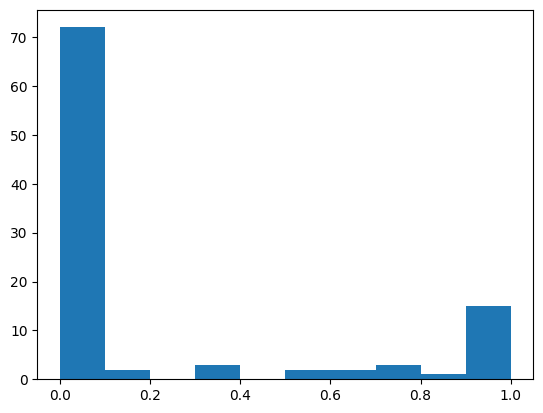

In [14]:
plt.hist(recalls)

In [15]:
np.mean(recalls)

0.21898686465686595

(array([ 9.,  2.,  3.,  1.,  0.,  1.,  2.,  1.,  2., 79.]),
 array([0.06969653, 0.16272688, 0.25575723, 0.34878757, 0.44181792,
        0.53484827, 0.62787861, 0.72090896, 0.81393931, 0.90696965,
        1.        ]),
 <BarContainer object of 10 artists>)

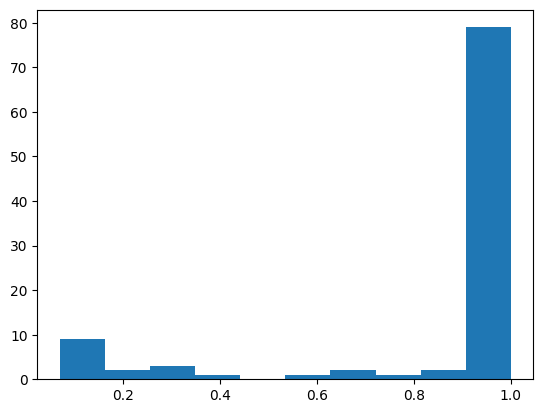

In [16]:
plt.hist(precisions)

In [17]:
np.unique(ths)

array([3.64873971, 3.72237281, 3.74178498, 3.76745905, 3.77835023,
       3.78855873, 3.79156282, 3.81264057, 3.83434597, 3.85067866,
       3.86510826, 3.88305482, 3.88937366, 3.89056724, 3.91053636,
       3.91614882, 3.92388536, 3.92664456, 3.94600224, 3.94757141,
       3.95034643, 3.95437578, 3.9586276 , 3.95997832, 3.96462071,
       3.96639466, 3.96753457, 3.97198696, 3.9720411 , 3.99007354,
       3.99582109, 3.9994429 , 4.00126652, 4.01741268, 4.02796766,
       4.02824417, 4.03661266, 4.04268995, 4.04833171, 4.0484536 ,
       4.0530089 , 4.05756003, 4.0578852 , 4.05799175, 4.06586718,
       4.07084219, 4.07303906, 4.07993764, 4.08443496, 4.08714316,
       4.08839015, 4.09467624, 4.10060769, 4.10503854, 4.11130484,
       4.11737868, 4.12105521, 4.12195841, 4.1228434 , 4.12874434,
       4.13212856, 4.13296407, 4.13490266, 4.13579456, 4.13932395,
       4.13958488, 4.14033834, 4.14329662, 4.14643447, 4.15399187,
       4.15667781, 4.15896194, 4.1596162 , 4.16201429, 4.16201

In [18]:
ths

array([[[4.13490266]],

       [[4.54969457]],

       [[4.36219428]],

       [[4.43110856]],

       [[4.00126652]],

       [[4.00126652]],

       [[4.41677713]],

       [[4.03661266]],

       [[4.36628229]],

       [[4.31515525]],

       [[4.22695302]],

       [[4.1731451 ]],

       [[3.97198696]],

       [[4.60037447]],

       [[4.86280143]],

       [[4.44630694]],

       [[4.36821962]],

       [[4.85981128]],

       [[4.15896194]],

       [[4.06586718]],

       [[4.30827349]],

       [[4.65165147]],

       [[4.19574053]],

       [[4.59972183]],

       [[4.05799175]],

       [[4.57124759]],

       [[4.33416592]],

       [[4.29917816]],

       [[4.28266271]],

       [[4.56880756]],

       [[3.9720411 ]],

       [[4.18771301]],

       [[4.64011374]],

       [[4.55030774]],

       [[4.14033834]],

       [[4.43433143]],

       [[4.00126652]],

       [[5.17558644]],

       [[4.19654574]],

       [[4.32686941]],

       [[4.28127426]],

       [[4.41602